In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

In [ ]:
#上限表示数を拡張
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 200)

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [ ]:
INPUT = "/content/drive/MyDrive/nishika/" # 所望のディレクトリに変更してください。
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [ ]:
embeded_train_image = pd.read_csv("/content/drive/MyDrive/nishika/embeded/embedding_train_image_SwinTransformerV2Base256.csv")
embeded_test_image = pd.read_csv("/content/drive/MyDrive/nishika/embeded/embedding_test_image_SwinTransformerV2Base256.csv")

In [ ]:
embeded_train_image = embeded_train_image.drop(["Unnamed: 0","text_len","odai_photo_file_name","id", "text","is_laugh"], axis=1)
embeded_test_image = embeded_test_image.drop(["Unnamed: 0","text_len","odai_photo_file_name","id", "text"], axis=1)

In [ ]:
embeded_train_text = pd.read_csv("/content/drive/MyDrive/nishika/embeded/embedding_train_text_ginza510_electra.csv")
embeded_test_text = pd.read_csv("/content/drive/MyDrive/nishika/embeded/embedding_test_text_ginza510_electra.csv")

In [ ]:
embeded_train_text = embeded_train_text.drop(["Unnamed: 0","id","text"], axis=1)
embeded_test_text = embeded_test_text.drop(["Unnamed: 0","id","text"], axis=1)

In [ ]:
embeded_train_image_text = pd.concat([embeded_train_image,embeded_train_text],axis=1)
embeded_test_image_text = pd.concat([embeded_test_image,embeded_test_text],axis=1)

In [ ]:
hash_df = pd.read_csv("/content/drive/MyDrive/nishika/output/hash_clustering_result.csv")

In [ ]:
hash_train_df = hash_df[hash_df['fold'] == 'train']
hash_test_df = hash_df[hash_df['fold'] == 'test']

In [ ]:
hash_train_df = hash_train_df.drop("fold", axis=1)
hash_test_df = hash_test_df.drop("fold", axis=1)

In [ ]:
print(hash_train_df)

       cluster_id        filename
0               0  9fkys1gb2r.jpg
1               1  c6ag0m1lak.jpg
2               2  whtn6gb9ww.jpg
3               3  6yk5cwmrsy.jpg
4               4  0i9gsa2jsm.jpg
...           ...             ...
24985       24914  5ctq9ohpge.jpg
24986       24915  dcj9pepjwf.jpg
24987       24916  ks04y4iy7i.jpg
24988       24917  cgfkktchbz.jpg
24989       24918  jwulli1cmi.jpg

[24962 rows x 2 columns]


In [ ]:
print(embeded_train_image_text)

In [ ]:
train = pd.merge(embeded_train_image_text, hash_train_df,left_on="odai_photo_file_name",right_on="filename")

In [ ]:
test = pd.merge(embeded_test_image_text, hash_test_df,left_on="odai_photo_file_name",right_on="filename")

In [ ]:
print(test)

In [ ]:
# 学習データと評価データに分割します
train, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train["is_laugh"])

train_y = train["is_laugh"]
train_x = train.drop(["odai_photo_file_name","filename","is_laugh"], axis=1)

valid_y = valid["is_laugh"]
valid_x = valid.drop(["odai_photo_file_name","filename","is_laugh"], axis=1)

test_x = test.drop(["odai_photo_file_name","filename"], axis=1)

In [ ]:
print(train_x)

       SwinTransformerV2Base256_0  SwinTransformerV2Base256_1  \
14264                   -1.189342                   -0.214029   
11377                    0.101341                    0.305727   
10900                   -0.452456                   -0.084194   
5588                    -0.344234                   -0.586962   
19719                   -0.142293                    0.006628   
...                           ...                         ...   
22080                   -0.344155                    0.179563   
4956                    -0.070379                    0.736285   
11820                    0.129459                   -0.265039   
8535                    -0.011213                   -0.348722   
1766                     0.187957                   -0.261085   

       SwinTransformerV2Base256_2  SwinTransformerV2Base256_3  \
14264                   -0.869415                    0.228487   
11377                   -0.165868                    0.132565   
10900                   

In [ ]:
print(train_x.shape)
print(valid_x.shape)

(19969, 1026)
(4993, 1026)


# Model

In [ ]:
lgbm_params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.05,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":5,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	train's binary_logloss: 0.609414	valid's binary_logloss: 0.657814
[100]	train's binary_logloss: 0.568716	valid's binary_logloss: 0.656661
Early stopping, best iteration is:
[82]	train's binary_logloss: 0.581897	valid's binary_logloss: 0.656544


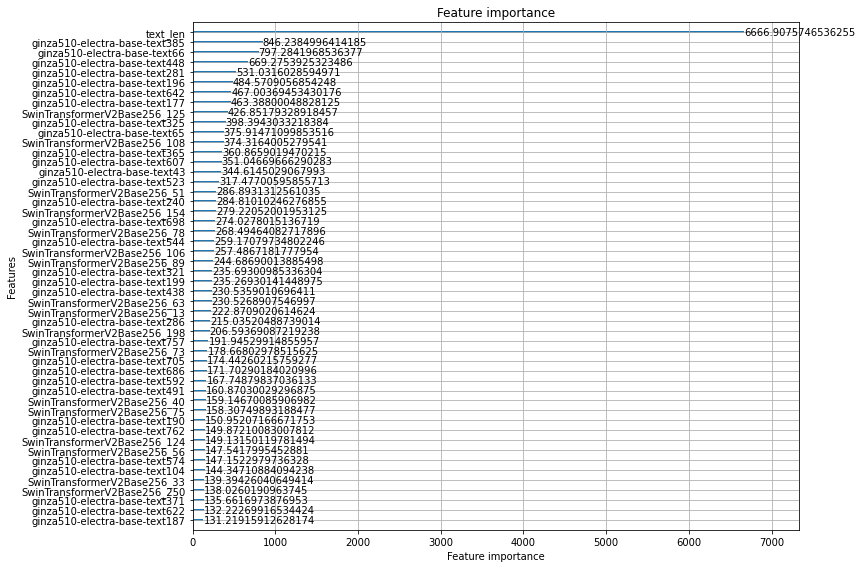

In [ ]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.6132585619867815


Text(0.5, 51.0, 'Predict')

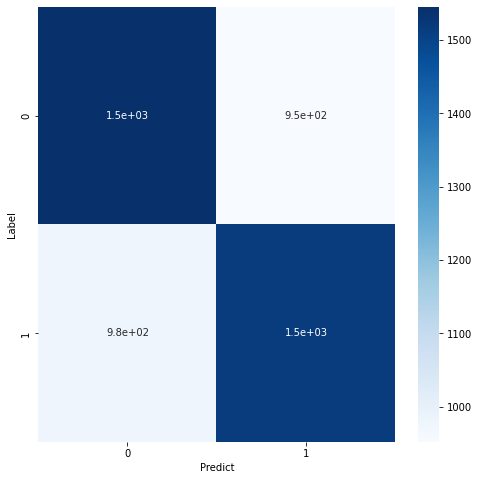

In [ ]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

# Predict

In [ ]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [ ]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.501073
1,tsgqmfpef,0.410821
2,owjcthkz2,0.432759
3,rvgaocjyy,0.465349
4,uxtwu5i69,0.770411


In [ ]:
submission_df.to_csv(('sub.csv'), index=False)

実際に提出して、スコアを確認してみましょう。  精度向上に向けて様々なアイディアがあるかと思いますので、ぜひいろいろとトライしていただければと思います！

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）


https://lab.mo-t.com/blog/kaggle-shopee
前処理については今回は気にしない。最終的なLightgbmにぶっこむ特徴量を増やして選別する方針でいく。
エンベッディングした結果は保存する。
最初は画像は画像、テキストはテキストでエンベッディングする。
画像のArcFaceちょっとめんどい、実装できそうならやる
knn(k=50)を使って、画像、テキストの分類自体はする。
https://www.kaggle.com/code/jyotmakadiya/shopee-groupkfolds-effnetb1-and-tfidf-or-bert

基本はエンベッディングしたものを使う。
プラスで、特徴量を足してみる。
乖離具合ってどうやって測定するのか
・長文？なんかキーになる話がある？画像と関係？わからん
・ボケのデザインパターン/ジョナサン・ハイト
・既知未知判定ってどうやってやるんだ・・・
・ポジネガ距離はおもろい。
あえて正しいこととは逆なことをして、許されるライン的な話。
→単純にえぐい言葉やえぐさを分類？なんかいいのないかな。
説明文とセリフ文→なんかいい楽な分類ないかな、なかったら頑張る。
画像に何が写っているか→うーん、手動しかないかも。